# SafetyTests for TrajPOMDP

An environment for obstacle avoidance tasks  
  
The basic idea is to have a 2D area with objects moving more or less randomly inside, and the ego vehicle has to drive safely inside.   

## POMDP model


* **States:** $\{(x,y,v_x,v_y)_{ego},{(x,y,v_x,v_y)_{obj}}_{1..n}\}$  
* **Actions:** $a_{longitudinal} \in [-2, -1, 0, 1, 2]$ $m.s^{-2}$ for ego speed increase. $a_{lateral}$ wil be added next
* **Observations:** obj observed via a Linear Gaussian Observation sensor model that is discretized.   
We can sense objects in a $200\:m \times 200\:m$ area. We will use a $1 \: m$ and $1 \: m.s^{-1}$ grids resolution.
* **Transitions:** Linear Gaussian Dynamics 
* **Rewards:** accounts for efficiency, comfort and safety. Discount factor: 0.9  
   

## How to define a Test Scenario

* Provide an initialisation function to setup: N objects and 1 ego vehicle with initial $[x,y,v_x,v_y]$ information. Called in **initialstate_distribution**  
* Define level of uncertainties for Transition and Observation Models: $\Sigma_s,\Sigma_o$. Called in **initialstate_distribution**  
* Define level of uncertainty associated to objects' intent: provide a function that will return a control command (corresponding to accelerations $[a_x, a_y]$). The basic idea is that by default an object moves at some constant speed, and from time to time, accelerate or decelarate during a short period of time. So basically we will sample some numbers: next time we accelerate/decelerate, with which magnitude and for how long. Called in ** 
generate_s**    
  
In this test environment, the n objects evolve independantly and we will ignore collisions in between the n objects. We just care about collisions with the ego vehicle.  
  

The test difficulty will be related to the number of objects and the different level of uncertainties. 
  
Use seeds to make the tests results reproducible.  
  
For an example: cf **scn1_init()** and **scn1_step()** examples below
  

## MCTS TreeSearch with BasicPOMCP in experimental_ttc1 mode

* Reduced Tree width 
* Easier analysis  
* More consistent and valuable statistics (N is bigger per observation nodes) that should provide better estimates of Q-values
* Rollout evaluation still done with legacy or continuous observations

In [ ]:
HTML("""<img src="img/BasicPOMCP-experimental_ttc1.png"/>""")

In [2]:
HTML("""<img src="img/BasicPomcp-obs_classes.png"/>""")

HTML{String}("<img src=\"img/BasicPomcp-obs_classes.png\"/>")

## MCTS TreeSearch with BasicPOMCP in default legacy mode

In [3]:
HTML("""<img src="img/BasicPOMCP.png"/>""")

HTML{String}("<img src=\"img/BasicPOMCP.png\"/>")

## POMCPSolver options

In [4]:
?POMCPSolver

search:

Couldn't find POMCPSolver
Perhaps you meant mapfoldr


No documentation found.

Binding `POMCPSolver` does not exist.


## Ongoing tests: BasicPOMCP modifications

We create a set of **observation classes** to make the tree search more efficient and safety aware.  
These classes are created with safety considerations in mind.  

>import Pkg  
>Pkg.dir("BasicPOMCP")  
  
Enables to locate files  
Do local modifications  
Kernel restart and clear output

>using BasicPOMCP  
  
Test if it is possible to aggregate observations nodes based on some external criteria  
Without changing KF BeliefUpdater which is required unchanged for ROLLOUT evaluation  

**Idea is: Reduce the width of the tree by grouping the observation nodes that should correspond to the same Utility so that overall computation is much more efficient .... Do not evaluate N functions if these N functions are expected to provide the same result ...**
  
Modifs in:
* solver.jl  
* rollout.jl  
* BasicPOMCP.jl  

In the tree we want to aggregate observation nodes corresponding to same TTC1 criteria. So basically we would be dealing with just a few observation nodes in the tree. 
But, during rollout we sample states from the belief which is updated via UpdateBelief(b, a, o) and here we want to deal with the original observation (not aggregated observation)  

So every observation, which is already discretized as $N \times [x,y,v_x,v_y]$ with Int values will be associated to 2 versions:  
* The observation in extension, as before, used by KF BeliefUpdater. Used to sample a state.
* The observation class, in compact form, to enable observations aggregation in the tree. Used to evaluate a Utility: we want to group all the nodes that should correspond to same Utility. Moreover this aggregation is done in a way to consider mainly pessimistic scenarios w.r.t. observations. We prefer sampling observations that correspond to critical use cases, so typically with a smaller TTC.      
  
  
 We create a set of **observation classes** to make the tree search more efficient. These classes are created with safety considerations in mind.  
   
Benchmark the 2 BasicPOMCP versions: TTC1pomcp (modified) vs REFpomcp (original)

## POMDP setup

First, we will define the problem with the generative interface - this is all that is needed to use the POMCP Planner.

In [5]:
using POMDPs
using Random
import POMDPs: initialstate_distribution, actions, n_actions, reward, generate_o, generate_s, discount, isterminal
Random.seed!(1);

In [6]:
using Distributions # for MvNormal
using LinearAlgebra
using Parameters # for @with_kw

In [7]:
#rng = Random.GLOBAL_RNG;
rng = MersenneTwister(2);

In [8]:
# Space, Action, Observations
# s: vector with 4 coordinates for ego + 4 coordinates for obj
# a an Int encoding an acceleration or deceleration step

# o : an Int cf get_safety_valued_o which works out an Int between 0 and 11 (TTC based)

const VecEgoObj = Array{Float64, 1}
abstract type AbstractTraj <: POMDP{VecEgoObj, Int, Vector{Int64}} end

In [9]:
# Trajectory Planner POMDP
@with_kw mutable struct TrajPOMDP <: AbstractTraj
    
    n_obj::Int = 1 # by default 1 obj in addition to ego vehicle
    discount_factor::Float64 = 0.9 # to account for decrasing precision in predictions

    # ---------------
    # safety related
    # ---------------
    smallest_TTC::Float64 = Inf # smallest Time To Collision
    smallest_TTC_obj::Int = -1 # obj with smallest TTC
    dist_collision::Float64 = 10 # We declare collision-event when dist ego-obj is below this threshold
    dist_nearest_obj::Float64 = Inf # initially we do not see obj

    # --------------
    # goals related
    # --------------
    goal::Vector{Float64} = [100.0, 200.0, 0.0, 0.0] # our goal: target state for ego
    # the ratio between the 2 below values measures progress
    dist_to_goal::Float64 = Inf # remaining dist to goal
    dist_start_to_goal::Float64 = Inf # 

    # ---------------
    # rewards related
    # ---------------
    r_comfort::Float64 = 0
    r_efficiency::Float64 = 0
    r_safety::Float64 = 0
    
    # initialized by initialstate_distribution
    σ2_state::Vector{Float64} = Float64[] # TODO this is redundant (stored in MvNormal belief...)
    # no need to explicity keep track of state here: we get s from POMDPs core framework
end

discount(p::TrajPOMDP) = p.discount_factor
isterminal(p::TrajPOMDP, s::VecEgoObj) = (get_dist_nearest_obj(p,s) <= p.dist_collision || s[2] >= p.goal[2]);

In [10]:
# Aligned settings with UrbanPOMDP

actions(::TrajPOMDP) = [-4, -2, 0, 2] # longitudinal acceleration
n_actions(::TrajPOMDP) = 4

n_actions (generic function with 1 method)

## Transition and Observation Models: Linear-Gaussian

Cf DMU book section 6.2.2: same notations used here       

### Transition model

In [11]:
# Aligned settings with UrbanPOMDP
#const dt = 0.5 # time step too much ... not realistic

const dt = 0.2 # time step

# s=[x,y,vx,vy]
const Ts = [1.0 0.0 dt  0.0;
           0.0 1.0 0.0 dt ;
           0.0 0.0 1.0 0.0;
           0.0 0.0 0.0 1.0]

# a = [ax, ay]
const Ta = [0.5*dt^2 0.0     ;
            0.0      0.5*dt^2;
            dt       0.0     ;
            0.0      dt      ]

# TODO: Exact values to be refined. So far assume not too stochastic ...
const Σs = Matrix(1e-10 * Diagonal{Float64}(I, 4)) # Process noise covariance

# Transition models for ego and obj
Transition_ego(s::Array{Float64,1}, a::Array{Float64,1}) = Ts*s + Ta*a
#Transit_obj(s, a, rng) = Ts*s + Ta*a + rand(rng, MvNormal(Σs))
Transition_obj(s, a, rng) = Ts*s + Ta*a # XXX so far ...

Transition_obj (generic function with 1 method)

### Observation model

Next, the observation model is defined. $h$ generates an observation (this is only used in the simulation, not in the filter), $g$ returns the relative likelyhood of an observation given the previous state, control, and current state.

In [12]:
# Linear observation model: we assume we observe directly s, so Identity matrix,  but it is noisy that's all...
const Os = Matrix(Diagonal{Float64}(I, 4)) # Process noise covariance


const Σo = Matrix(3.00 * Diagonal{Float64}(I, 4)) # Measurement noise covariance

Observation_obj(s, rng) = rand(rng, MvNormal(Os*s, Σo))
#llh_obj(x0, u, x, y) = pdf(MvNormal(x, Σo), y)

Observation_obj (generic function with 1 method)

## Some useful functions

In [13]:
function get_dist(obj1::Vector{Float64}, obj2::Vector{Float64})
    sqrt((obj1[1]-obj2[1])^2 + (obj1[2]-obj2[2])^2)
end

get_dist (generic function with 1 method)

In [14]:
function get_dist_nearest_obj(p::TrajPOMDP, s::VecEgoObj)
    ego = s[1:4]
    
    dist_nearest_obj = Inf
    num_nearest_obj = -1
    
    idx = 5
    for n in 1:p.n_obj
        obj = s[idx:idx+3]
        dist = get_dist(ego, obj)
        
        if dist < dist_nearest_obj
            dist_nearest_obj = dist
            num_nearest_obj = n
        end
        idx += 4
    end
    
    return dist_nearest_obj
end

get_dist_nearest_obj (generic function with 1 method)

In [15]:
function get_dist_to_goal(p::TrajPOMDP, s::VecEgoObj)
    return get_dist(s[1:4], p.goal)
end

get_dist_to_goal (generic function with 1 method)

### Time To Collision

We want to find out the TTC between ego and each object objects  
This is a key information in the decision making process  

For the TTC between 2 objects:  
* Compute $t=TTC$ such that distance$(\begin{bmatrix}x_1+\dot{x_1}t \\ y_1+ \dot{y_1}t \end{bmatrix} - \begin{bmatrix}x_2+\dot{x_2}t \\ y_2+\dot{y_2}t \end{bmatrix}) <= R$    
* R should be replaced by the delta of the 2 objects' radius... i.e. when they collide...    
* That's just a quadratic equation in t  

$[(x_1 - x_2) + (\dot{x}_1 - \dot{x}_2)t]^2 + [(y_1 - y_2) + (\dot{y}_1 - \dot{y}_2)t]^2 \leq R$

$ t^2 [(\dot{x}_1 - \dot{x}_2)^2+(\dot{y}_1 - \dot{y}_2)^2] + 2t [(x_1 - x_2)(\dot{x}_1-\dot{x}_2)+(y_1 - y_2) (\dot{y}_1 - \dot{y}_2)] + [(x_1 - x_2)^2 + (y_1 - y_2)^2] \leq R$

Let's find $t=TTC$ s.t.:
$$ at^2 + bt + c = 0$$  
with:  
* $a=[(\dot{x}_1 - \dot{x}_2)^2+(\dot{y}_1 - \dot{y}_2)^2]$   
* $b= 2 [(x_1 - x_2)(\dot{x}_1 - \dot{x}_2)+(y_1 - y_2) (\dot{y}_1 - \dot{y}_2)]$  
* $c=[(x_1 - x_2)^2 + (y_1 - y_2)^2] - R^2$  

In [16]:
function get_TTC(ego::Vector{Float64}, obj::Vector{Float64}, radius::Float64)
        
    x1 = ego[1] ; y1 = ego[2]; vx1 = ego[3]; vy1 = ego[4]
    x2 = obj[1] ; y2 = obj[2]; vx2 = obj[3]; vy2 = obj[4]
            
    a = (vx1 - vx2)^2 + (vy1 - vy2)^2
    b = 2 * ((x1 - x2) * (vx1 - vx2) + (y1 - y2) * (vy1 - vy2))
    c = (x1 - x2)^2 + (y1 - y2)^2 - radius^2 # TODO remove harcoded value
        
    if a == 0 && b == 0
        if c == 0
            return 0
        else
            return Inf
        end
    end
    
    if a == 0 && b != 0
        t = -c/b
        if t < 0
            return Inf
        else
            return t
        end
    end
    
    Δ = b^2 - 4*a*c
    if Δ < 0
        return Inf
    end
    
    t1 = (-b-sqrt(Δ))/(2*a)
    t2 = (-b+sqrt(Δ))/(2*a)  
    if t1 < 0
        t1 = Inf
    end
    
    if t2 < 0
        t2 = Inf
    end
    
    return min(t1, t2)    
end;

In [17]:
function get_smallest_TTC(s::VecEgoObj)
    
    radius = 15.0
    ego = s[1:4]
    
    
    smallest_TTC = Inf
    smallest_TTC_obj = -1
    
    idx = 5
    for n in 1:Int64((length(s)-4)/4)
        obj = s[idx:idx+3]
        TTC = get_TTC(ego, obj, radius)
        
        if TTC < smallest_TTC
            smallest_TTC = TTC
            smallest_TTC_obj = n
        end
        idx += 4
    end
    
    return smallest_TTC, smallest_TTC_obj
end

get_smallest_TTC (generic function with 1 method)

In [18]:
# just checking
obj1=[0.0, 100, 20, 0]
obj2=[100, 0.0, 0, 20]
println("dist: ", get_dist(obj1, obj2))
println("TTC: ", get_TTC(obj1, obj2, 15.0))

dist: 141.4213562373095
TTC: 4.4696699141100895


## Generative models for POMCP

In [19]:
function generate_s(p::TrajPOMDP, s::Array{Float64,1}, a::Int, rng::AbstractRNG)    
    s_ego = s[1:4]
    a_ego = [0.0, a]
    sp_ego = Transition_ego(s_ego, a_ego)
    
    sp = sp_ego
    
    idx = 5
    for n in 1:p.n_obj
        s_obj = s[idx:idx+3]
        #a_obj = scn1_step(s, n) # [0.0 , 0.0] # XXX for now on ...
        a_obj = scn2_step(s, n) # [0.0 , 0.0] # XXX for now on ...
        sp_obj = Transition_obj(s_obj, a_obj, rng)
        sp = vcat(sp, sp_obj)
        idx += 4
    end
    
    return sp
end

generate_s (generic function with 2 methods)

In [20]:
# TODO: The farther away the bigger the sensor error will be 
#obs_std(ego::Vec2, obj::Vec2) = sqrt(0.5*((ego[1]-obj[1])^2 + (ego[2]-obj[2])^2))


In [21]:

function get_safety_valued_o(s_ego::Vector{Float64}, o::Vector{Int})
    smallest_TTC, smallest_TTC_obj = get_smallest_TTC(vcat(s_ego, Float64.(o)))
    smallest_TTC = min(smallest_TTC, 11)
    smallest_TTC = trunc(Int, smallest_TTC)
    return (smallest_TTC)
end

get_safety_valued_o (generic function with 1 method)

In [22]:
# we return a discrete observation (out of a continuous distribution...)
function generate_o(p::TrajPOMDP, s::VecEgoObj, a::Int, sp::VecEgoObj, rng::AbstractRNG)
    
    ### !!! Reduce the number of observations per action to constraint tree search size !!!
    #mu_o = sp[3]
    #std_o = 1
    #observations = [mu_o - std_o, mu_o, mu_o + std_o]
    #o = observations[ rand(1:3) ]
    #x_o = min(round(o), 199)
    #y_o = round(sp[4])
    #return Int64(200 * y_o + x_o)
    
    #o = rand(rng, MvNormal(sp, diagm(0 => [1e-10, 1e-10, 1e-10, 1e-10, 1, 1, 1, 1]) ))
    
    # NB: with BasicPOMCP experimental_ttc1 we can use continuous observations as well
    # without side effects
    
    o = Int64[]
    idx = 5
    for n in 1:p.n_obj
        o_obj = Observation_obj(sp[idx:idx+3], rng) # vector with 4 continuous components
        o = vcat(o, round.(Int64, o_obj)) # Discretized observation
        idx += 4
    end
    
    # Integer between 0 and 11
    #safety_valued_o = get_safety_valued_o(sp[1:4], o)
    #return safety_valued_o
    
    return o
end

generate_o (generic function with 2 methods)

In [24]:
function reward(p::TrajPOMDP, s::VecEgoObj, a::Int, sp::VecEgoObj)
    
    # Keep track for visualization, plots ...
    p.dist_to_goal = get_dist_to_goal(p, sp)
    p.dist_nearest_obj = get_dist_nearest_obj(p, sp)
    p.smallest_TTC, p.smallest_TTC_obj = get_smallest_TTC(sp)
    
    # We are dealiong with 3 types of objectives:
    # - COMFORT (weiht 1)
    # - EFFICIENCY (weight 10)
    # - SAFETY (weight 100)
    
    r_comfort = r_efficiency = r_safety = 0
        
    if p.smallest_TTC <= 10.0
        r_safety += -10 - (10 - p.smallest_TTC) * 10 # between [-100, 0]
    end
    
    # SAFETY related + terminal state (overwrite)
    if p.dist_nearest_obj <= p.dist_collision
        r_safety += -1000
    end
    
    # The faster we go in this test setup
    r_efficiency += a
    
    if a < -2
        r_comfort += -1
    end
    
    # Keep track for visualization, plots ...
    p.r_comfort = r_comfort
    p.r_efficiency = r_efficiency
    p.r_safety = r_safety
    
    return r_comfort + r_efficiency + r_safety
end;

In [25]:
# function initialstate_distribution(p::TrajPOMDP)
#     println("initialstate_distribution")
#     # s = [x, y, vx, vy]
    
#     p.n_obj = 10 # XXXX
    
#     ego = [100.0,   0.0,  0.0,  20.0] # moves along y-axis from 0 to 200
#     σ2_ego = [1e-10, 1e-10, 1e-10, 1e-10]
    
#     p.goal = [100.0, 200.0, 0.0, 0.0] # our goal: target state for ego
#     p.dist_start_to_goal = get_dist(ego, p.goal)
    
#     obj = [0.0,   100.0, 20.0,   0.0] # moves along x-axis
#     σ2_obj = [1.0, 1, 1, 1]
    
#     state = vcat(ego, obj)
#     p.σ2_state = vcat(σ2_ego, σ2_obj)
    
#     for n in 2:p.n_obj
#         # TODO randomize some more things
#         obj[2] += 9 # space out objects
#         state = vcat(state, obj)
#         p.σ2_state = vcat(p.σ2_state, σ2_obj)
#     end
    
#     println(typeof(state))
#     return MvNormal(state, diagm(0 => p.σ2_state))
# end;

In [26]:
function randomize_initialstate()
    μ, vector_σ2 = scn2_init(TrajPOMDP())
    global tested_initialstate = MvNormal(μ, diagm(0 => vector_σ2))
end

randomize_initialstate (generic function with 1 method)

In [27]:
randomize_initialstate()

UndefVarError: UndefVarError: scn2_init not defined

In [28]:
# To make tests reproducible

function initialstate_distribution(p::TrajPOMDP)
    println("initialstate_distribution")
    
    #μ, vector_σ2 = scn1_init(p)
    μ, vector_σ2 = scn2_init(p)
    global tested_initialstate = MvNormal(μ, diagm(0 => vector_σ2)) 
    return tested_initialstate
end;

## Defining Test Scenarios

### How to define a Test Scenario

* Provide an initialisation function to setup: N objects and 1 ego vehicle with initial $[x,y,v_x,v_y]$ information. Called in **initialstate_distribution**  
* Define level of uncertainties for Transition and Observation Models: $\Sigma_s,\Sigma_o$. Called in **initialstate_distribution**  
* Define level of uncertainty associated to objects' intent: provide a function that will return a control command (corresponding to accelerations $[a_x, a_y]$). The basic idea is that by default an object moves at some constant speed, and from time to time, accelerate or decelarate during a short period of time. So basically we will sample some numbers: next time we accelerate/decelerate, with which magnitude and for how long. Called in ** 
generate_s**    

In [29]:
# Trajectory Planner SCENARIO

# For every object
@with_kw mutable struct objSCN
    # ---------------------------
    # so far we do not change ay
    # ---------------------------
    state::Symbol = :sinit # :sinit :sconstant_speed :saccel_decel
    next_trigger_ax::Float64 = 30.0 # in 25..35 meters random uniform
    ax_cmd::Int64 = 0 # -1 0 1 random uniform on ax
    ay_cmd::Int64 = 0 # -1 0 1 random uniform on ax
    ax_duration::Int64 = 3 # 1 2 3 random uniform
end

@with_kw mutable struct TestSCN
    # Covariance matrix for Transition Model
    Σs::Array{Float64,2} = Matrix(1e-10 * Diagonal{Float64}(I, 4))
    # Covariance matrix for Motion Model
    Σo::Array{Float64,2} = Matrix(1.00 * Diagonal{Float64}(I, 4))
    
    n_obj::Int = 3 # by default 3 obj in addition to ego vehicle
    obj::Vector{objSCN} = objSCN[]
end

TestSCN

In [30]:
testscn = TestSCN() # THE ONLY GLOBAL VARIABLE HERE ... with rng !!!! TODO CHECK THAT ....

TestSCN
  Σs: Array{Float64}((4, 4)) [1.0e-10 0.0 0.0 0.0; 0.0 1.0e-10 0.0 0.0; 0.0 0.0 1.0e-10 0.0; 0.0 0.0 0.0 1.0e-10]
  Σo: Array{Float64}((4, 4)) [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
  n_obj: Int64 3
  obj: Array{objSCN}((0,))


In [31]:
Float64(rand(rng, -1:1))

1.0

In [32]:
# ------------------------------------------------------
# From 1 scenario to the other:
# to change LEVEL OF UNCERTAINTIES => change rand RANGES
# ------------------------------------------------------

function scn1_step(s::VecEgoObj, num_obj::Int)
    #return [0.0 , 0.0] # XXX TODO by default (remove that)
    
    #return [0.0 , -1.0]
    
    obj_x = s[5+(num_obj-1)*4]
    obj_ax = 0
    obj_ay = 0
    
    obj = testscn.obj[num_obj]
        
    if obj.state == :sinit
        
        obj.next_trigger_ax = obj_x + Float64(rand(rng, 20:30)) # XXX RAND
        obj.state = :sconstant_speed
        
    elseif obj.state == :sconstant_speed
        
        if obj_x >= obj.next_trigger_ax
            obj.ax_cmd = rand(rng, -1:1) # XXX RAND
            obj.ay_cmd = rand(rng, -1:1) # XXX RAND
            obj.ax_duration = rand(rng, 1:5) # XXX RAND
            obj.state = :saccel_decel
        end
        
    elseif obj.state == :saccel_decel
        obj_ax = obj.ax_cmd
        obj_ay = obj.ay_cmd
        obj.ax_duration -= 1
        if obj.ax_duration <= 0
            obj.state = :sinit
        end
    end
    
    return [obj_ax, obj_ay]
end

scn1_step (generic function with 1 method)

In [33]:
# ------------------------------------------------------
# From 1 scenario to the other:
# change n_obj and INIT vallues
# ------------------------------------------------------

function scn1_init(p::TrajPOMDP)
    p.n_obj = 10 # XXX INIT
    
    for n in 1:p.n_obj
        obj = objSCN()
        push!(testscn.obj, obj)
    end
    
    ego = [100.0,   0.0,  0.0,  20.0] # moves along y-axis from 0 to 200
    σ2_ego = [1e-10, 1e-10, 1e-10, 1e-10]
    
    p.goal = [100.0, 200.0, 0.0, 0.0] # our goal: target state for ego
    p.dist_start_to_goal = get_dist(ego, p.goal)
    
    obj = [0.0,   100.0, 20.0,   0.0] # moves along x-axis XXX INIT
    σ2_obj = [1.0, 1, 1, 1]
    
    state = vcat(ego, obj)
    σ2_state = vcat(σ2_ego, σ2_obj)
    
    for n in 2:p.n_obj
        obj[2] += 9 # space out objects  XXX INIT
        state = vcat(state, obj)
        σ2_state = vcat(σ2_state, σ2_obj)
    end
    
    p.σ2_state = σ2_state
    
    return state, σ2_state
end

scn1_init (generic function with 1 method)

In [34]:
# ------------------------------------------------------
# From 1 scenario to the other:
# change n_obj and INIT vallues
# ------------------------------------------------------

# Randomize moving objects on the test scene

function scn2_init(p::TrajPOMDP)
    n1 = 5
    n2 = 5
    
    p.n_obj = n1 + n2 # XXX INIT
    
    for n in 1:p.n_obj
        obj = objSCN()
        push!(testscn.obj, obj)
    end
    
    ego = [100.0,   0.0,  0.0,  20.0] # moves along y-axis from 0 to 200
    σ2_ego = [1e-10, 1e-10, 1e-10, 1e-10]
    
    p.goal = [100.0, 200.0, 0.0, 0.0] # our goal: target state for ego
    p.dist_start_to_goal = get_dist(ego, p.goal)
    
    obj = [0.0,   100.0, 20.0,   0.0] # moves along x-axis XXX INIT
    σ2_obj = [1.0, 1, 1, 1]
    
    state = vcat(ego, obj)
    σ2_state = vcat(σ2_ego, σ2_obj)
    
    for n in 1:n1
        x = rand(rng, 0:50)
        y = rand(rng, 25:190)
        vx = rand(rng, 10:25)
        vy = rand(rng, 0:5)
        obj = Float64.([x, y, vx, vy])
        state = vcat(state, obj)
        σ2_state = vcat(σ2_state, σ2_obj)
    end

    for n in 1:n2
        x = rand(rng, 150:200)
        y = rand(rng, 25:190)
        vx = -rand(rng, 10:25)
        vy = -rand(rng, 0:5)
        obj = Float64.([x, y, vx, vy])
        state = vcat(state, obj)
        σ2_state = vcat(σ2_state, σ2_obj)
    end
    
    p.σ2_state = σ2_state
    
    return state, σ2_state
end

scn2_init (generic function with 1 method)

In [35]:
# ------------------------------------------------------
# From 1 scenario to the other:
# to change LEVEL OF UNCERTAINTIES => change rand RANGES
# ------------------------------------------------------

# Constant speed tests
# As acceleration is not captured neither in state nor in obs in these tests

function scn2_step(s::VecEgoObj, num_obj::Int)
    return [0.0 , 0.0]
end

scn2_step (generic function with 1 method)

## Kalman Filter

## Implementing a Kalman Filter Belief Updater

In [36]:
pomdp = TrajPOMDP()
b = initialstate_distribution(pomdp)

initialstate_distribution


FullNormal(
dim: 48
μ: [100.0, 0.0, 0.0, 20.0, 0.0, 100.0, 20.0, 0.0, 31.0, 170.0  …  -15.0, -4.0, 193.0, 187.0, -19.0, -4.0, 172.0, 174.0, -24.0, -1.0]
Σ: [1.0e-10 0.0 … 0.0 0.0; 0.0 1.0e-10 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


Notations notes de Simon  

**Algorithm Kalman_filter$(\mu_{t−1} , \Sigma_{t−1} , u_t , z_t)$:**  
  
Motion update:  
* $\mu'_t = A_t μ_{t−1} + B_t u_t$
* $\Sigma'_t = A_t \: \Sigma_{t−1} \: A_t^T + R_t$  
  
Measurement update:  
* $S = C_t \: \Sigma'_t \: C_t^T + Q_t$
* $K_t = \Sigma'_t \: C_t^T \: S^{−1}$
* $\mu_t = \mu'_t + K_t \: (z_t − C_t \: \mu'_t )$
* $\Sigma_t = (I − K_t \: C_t) \: \Sigma'_t$
* return  $\: \mu_t , \Sigma_t$

In [37]:
struct TrajPOMDPKalman <: Updater
    pomdp::TrajPOMDP
    # Transition model
    A::Array{Float64,2}
    B::Array{Float64,2}
    R::Array{Float64,2}
    # Observation model
    C::Array{Float64,2}
    Q::Array{Float64,2}
end
TrajPOMDPKalman(pomdp::TrajPOMDP) = TrajPOMDPKalman(pomdp, Ts, Ta, Σs, Os, Σo)

TrajPOMDPKalman

Notations for Prediction update:
* position: $\mathcal{N}(x,P)$  
* linear motion model F where we apply a motion control: $\mathcal{N}(u,Q)$  
  
Prediction update rules:
* $x'=Fx+u$  
* $P'=FPF^T + Q$  
  
Notations for Motion update:
* linear observation model H with an observation cocariance matrix R  
  
Motion update rules:  
* $y=o-Hx'$  
* $S=HP'H^T + R$
* $K=P'H^TS^{-1}$  : Kalman FIlter Gain
  
* $x=x'+Ky$ : new mean for the position
* $P=(I-KH)P'$: new covariance matrix for the position

**Algorithm Kalman_filter$(\mu_{t−1} , \Sigma_{t−1} , u_t , z_t)$:**  
  
Motion update:  
* $\mu'_t = A_t μ_{t−1} + B_t u_t$
* $\Sigma'_t = A_t \: \Sigma_{t−1} \: A_t^T + R_t$  
  
Measurement update:  
* $S = C_t \: \Sigma'_t \: C_t^T + Q_t$
* $K_t = \Sigma'_t \: C_t^T \: S^{−1}$
* $\mu_t = \mu'_t + K_t \: (z_t − C_t \: \mu'_t )$
* $\Sigma_t = (I − K_t \: C_t) \: \Sigma'_t$
* return  $\: \mu_t , \Sigma_t$

In [38]:
function POMDPs.update(kf::TrajPOMDPKalman, b::MvNormal, a::Int, o::Vector{Int})
    # For Transition update
    A = kf.A; B = kf.B; R = kf.R
    # For Measurement update
    C = kf.C; Q = kf.Q
    
    # ----------
    # Handle ego 
    # ----------
    s = b.μ[1:4]
    u = [0.0, a]
    sp = A * s + B * u
    
    new_b = sp
    # no uncertainty change for ego
    new_σ2 = kf.pomdp.σ2_state[1:4] #  [1e-10, 1e-10, 1e-10, 1e-10 ]

    idx = 5
    for n in 1:kf.pomdp.n_obj
        # ----------
        # Handle obj (single obj so far)
        # ----------
        # KF prediction step
        μ = b.μ[idx:idx+3] # x,y,vx,vy
        Σ = diagm(0 => kf.pomdp.σ2_state[idx:idx+3])
        u = [0.0, 0.0] # TODO assume so far that we have no info on obj accelerations
    
        μp = A * μ + B * u
        Σp = A * Σ * transpose(A) + R
    
        # KF measurement step
        S = C * Σp * transpose(C) + Q
        K = Σp * transpose(C) * inv(S)
    
        z = o[idx-4:idx-1]
        μ = μp + K * (z - C * μp)
        Σ = (I - K * C) * Σp
        
        new_b = vcat(new_b, μ)
        new_σ2 = vcat(new_σ2, diag(Σ))        
        idx += 4
    end
    kf.pomdp.σ2_state = new_σ2
        
    #new_b_mean = [sp, μ]
    #new_sigma2 = [ [1e-10, 1e-10, 1e-10, 1e-10], diag(Σ)]
    
    #println("update: new_b=$new_b")    
    return MvNormal(new_b, diagm(0 => new_σ2))
end

In [39]:
up = TrajPOMDPKalman(pomdp)

TrajPOMDPKalman(TrajPOMDP
  n_obj: Int64 10
  discount_factor: Float64 0.9
  smallest_TTC: Float64 Inf
  smallest_TTC_obj: Int64 -1
  dist_collision: Float64 10.0
  dist_nearest_obj: Float64 Inf
  goal: Array{Float64}((4,)) [100.0, 200.0, 0.0, 0.0]
  dist_to_goal: Float64 Inf
  dist_start_to_goal: Float64 200.0
  r_comfort: Float64 0.0
  r_efficiency: Float64 0.0
  r_safety: Float64 0.0
  σ2_state: Array{Float64}((48,)) [1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
, [1.0 0.0 0.2 0.0; 0.0 1.0 0.0 0.2; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.02 0.0; 0.0 0.02; 0.2 0.0; 0.0 0.2], [1.0e-10 0.0 0.0 0.0; 0.0 1.0e-10 0.0 0.0; 0.0 0.0 1.0e-10 0.0; 0.0 0.0 0.0 1.0e-10], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [3.0 0.0 0.0 0.0; 0.0 3.0 0.0 0.0; 0.0 0.0 3.0 0.0; 0.0 0.0 0.0 3.0])

## Random policy tests

In [40]:
using POMDPPolicies
using POMDPSimulators

pomdp = TrajPOMDP()
rand_policy = RandomPolicy(pomdp);

In [41]:
b = initialstate_distribution(pomdp);
a = action(rand_policy, b);
println("""
    POMCP Recommends action $a for belief $b.

(this may be a bad choice because ... it is random...)
""")

initialstate_distribution
    POMCP Recommends action 0 for belief FullNormal(
dim: 48
μ: [100.0, 0.0, 0.0, 20.0, 0.0, 100.0, 20.0, 0.0, 40.0, 111.0, 17.0, 0.0, 22.0, 48.0, 17.0, 4.0, 24.0, 182.0, 10.0, 1.0, 1.0, 29.0, 15.0, 3.0, 7.0, 36.0, 11.0, 1.0, 181.0, 35.0, -10.0, 0.0, 167.0, 67.0, -17.0, -3.0, 188.0, 85.0, -25.0, -4.0, 184.0, 41.0, -22.0, 0.0, 184.0, 159.0, -10.0, -2.0]
Σ: [1.0e-10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0e-10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0e-10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0e-10 0.0 

In [42]:
tested_initialstate

FullNormal(
dim: 48
μ: [100.0, 0.0, 0.0, 20.0, 0.0, 100.0, 20.0, 0.0, 40.0, 111.0  …  -25.0, -4.0, 184.0, 41.0, -22.0, 0.0, 184.0, 159.0, -10.0, -2.0]
Σ: [1.0e-10 0.0 … 0.0 0.0; 0.0 1.0e-10 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


In [43]:
for (s,a,r,sp,o) in stepthrough(pomdp, rand_policy, "sarspo", max_steps=10)
    #@show (s,a,r,sp,o)
    @show (a,r,o)
end

initialstate_distribution
(a, r, o) = (0, -89.07468656655911, [2, 105, 18, 2, 33, 180, 7, 0, 5, 82, 8, 1, 38, 33, 12, 2, 40, 53, 21, 2, 6, 101, 13, -3, 193, 169, -20, -2, 168, 78, -19, -5, 164, 71, -22, -5, 166, 53, -12, -3])
(a, r, o) = (-4, -95.54510031039464, [8, 103, 20, 3, 35, 181, 10, -2, 11, 79, 10, 0, 39, 39, 12, 5, 45, 53, 22, 4, 8, 99, 13, 1, 189, 167, -22, -8, 161, 77, -24, -7, 161, 63, -24, -7, 160, 51, -15, -1])
(a, r, o) = (-2, -94.27681335536158, [12, 104, 15, -1, 38, 181, 13, 5, 11, 79, 8, 5, 43, 35, 11, 3, 53, 55, 23, 3, 13, 98, 9, 1, 187, 167, -18, -4, 154, 78, -21, -5, 155, 68, -26, -4, 162, 53, -12, -3])
(a, r, o) = (-2, -96.01757310194733, [14, 105, 19, 1, 40, 184, 9, 2, 14, 81, 13, 3, 49, 39, 16, 4, 55, 56, 23, 4, 15, 100, 9, -1, 180, 168, -19, -8, 152, 77, -21, -6, 151, 62, -25, -6, 156, 52, -16, -4])
(a, r, o) = (2, -94.24691800194482, [14, 105, 18, 2, 42, 183, 12, -1, 17, 81, 9, 3, 48, 38, 11, 4, 63, 52, 25, 1, 17, 97, 12, -2, 175, 165, -23, -3, 145, 76, -24, -

## Using the POMCP Planner

In [44]:
using BasicPOMCP

In [45]:
?POMCPSolver

search: POMCPSolver AbstractPOMCPSolver



```
POMCPSolver(#=keyword arguments=#)
```

Partially Observable Monte Carlo Planning Solver.

## Keyword Arguments

  * `max_depth::Int`   Rollouts and tree expension will stop when this depth is reached.   default: `20`
  * `c::Float64`   UCB exploration constant - specifies how much the solver should explore.   default: `1.0`
  * `tree_queries::Int`   Number of iterations during each action() call.   default: `1000`
  * `max_time::Float64`   Maximum time for planning in each action() call.   default: `Inf`
  * `tree_in_info::Bool`   If `true`, returns the tree in the info dict when action_info is called.   default: `false`
  * `experimental_ttc1::Bool`   If `true`, runs BasicPOMCP in experimental ttc1 mode (with observations class nodes)   default: `false`
  * `dump_action_vales::Bool`   If `true`, dump action values estimated by POMCP   default: `false`
  * `estimate_value::Any`   Function, object, or number used to estimate the value at the leaf nodes.   default: `RolloutEstimator(RandomSolver(rng))`

      * If this is a function `f`, `f(pomdp, s, h::BeliefNode, steps)` will be called to estimate the value.
      * If this is an object `o`, `estimate_value(o, pomdp, s, h::BeliefNode, steps)` will be called.
      * If this is a number, the value will be set to that number

    Note: In many cases, the simplest way to estimate the value is to do a rollout on the fully observable MDP with a policy that is a function of the state. To do this, use `FORollout(policy)`.
  * `default_action::Any`   Function, action, or Policy used to determine the action if POMCP fails with exception `ex`.   default: `ExceptionRethrow()`

      * If this is a Function `f`, `f(pomdp, belief, ex)` will be called.
      * If this is a Policy `p`, `action(p, belief)` will be called.
      * If it is an object `a`, `default_action(a, pomdp, belief, ex)` will be called, and if this method is not implemented, `a` will be returned directly.
  * `rng::AbstractRNG`   Random number generator.   default: `Random.GLOBAL_RNG`


In [46]:
# Using a tree_queries of 10000 provides much better results vs 16 but is much slower
# tree_querries = 1000 looks like a reasonable tradeoff


# By default we configure with the best settings based on our benchmarks results (cf report)
solver = POMCPSolver(tree_queries=1000, c=10, max_depth=20, dump_action_values=false, experimental_ttc1=true)




POMCPSolver
  max_depth: Int64 20
  c: Float64 10.0
  tree_queries: Int64 1000
  max_time: Float64 Inf
  tree_in_info: Bool false
  experimental_ttc1: Bool true
  dump_action_values: Bool false
  default_action: ExceptionRethrow ExceptionRethrow()
  rng: MersenneTwister
  estimate_value: RolloutEstimator


In [47]:
pomdp = TrajPOMDP()
planner = solve(solver, pomdp);

In [48]:
b = initialstate_distribution(pomdp)
a = action(planner, b)
println("""
    POMCP Recommends action $a for belief $b.

    (this may be a bad choice because the POMCP Parameters are set to their defaults.)
""")

initialstate_distribution
    POMCP Recommends action -4 for belief FullNormal(
dim: 48
μ: [100.0, 0.0, 0.0, 20.0, 0.0, 100.0, 20.0, 0.0, 15.0, 100.0, 10.0, 2.0, 22.0, 84.0, 17.0, 5.0, 2.0, 90.0, 18.0, 0.0, 30.0, 30.0, 20.0, 1.0, 41.0, 182.0, 21.0, 3.0, 182.0, 131.0, -12.0, -2.0, 172.0, 172.0, -24.0, -5.0, 163.0, 164.0, -12.0, -1.0, 167.0, 177.0, -18.0, 0.0, 193.0, 145.0, -20.0, 0.0]
Σ: [1.0e-10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0e-10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0e-10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0e-1

In [49]:
using POMDPModels
using POMDPModelTools

In [ ]:
min_etime = Inf
for i in 1:10
    etime = @elapsed a, info = action_info(planner, initialstate_distribution(pomdp))
    if etime < min_etime
        min_etime = etime
    end
    #@show etime, a
end

println(min_etime)

In [50]:
using Plots
using Printf

In [51]:
plots = [] # for visu but please note that it slows down the steps
steps = 0

r_eff = r_com = r_saf = 0
nsteps = 120

for (s,a,r,sp,o) in stepthrough(pomdp, planner, up, "sarspo", max_steps=nsteps)
    #@show (s,a,r,sp,o)
    @show (a,r,o)
    
    string_label = @sprintf "Step %d with action %d reward %.2f" steps a r
    
    string_text1 = @sprintf "R_com %.2f, R_eff %.2f, R_saf %.2f" pomdp.r_comfort pomdp.r_efficiency pomdp.r_safety
    string_text2 = @sprintf "TTC %.2f seconds, D_min %.2f meters" pomdp.smallest_TTC pomdp.dist_nearest_obj
    println(string_label)
    
    plt = scatter([s[1]], [s[2]], color=:blue, markersize=3, xlim=(0,200), ylim=(0,200), label=string_label)
    plot!(plt, [s[1], s[1]+s[3]], [s[2], s[2]+s[4]], arrow=true, color=:blue, label="")
    scatter!(plt, annotation=[ (50,185, string_text1, 8) ])
    scatter!(plt, annotation=[ (50,175, string_text2, 8) ])
    
    v = sqrt(s[3]^2+s[4]^2)
    string_v = @sprintf "v=%.1f m.s-1" v
    scatter!(plt, annotation=[ (s[1]+15,s[2], string_v, 8) ])
    
    idx = 1
    for n in 1:pomdp.n_obj
        
        if n == pomdp.smallest_TTC_obj
            cobj = :red
        else
            cobj = :green
        end
        
        # Plot TRUE STATE
        scatter!(plt, [s[idx+4]], [s[idx+5]], color=cobj, markersize=3, xlim=(0,200), ylim=(0,200), label="")
        plot!(plt, [s[idx+4], s[idx+4]+s[idx+6]], [s[idx+5], s[idx+5]+s[idx+7]], arrow=true, color=cobj, label="")
        
        v = sqrt(s[idx+6]^2+s[idx+7]^2)
        string_v = @sprintf "v=%.1f m.s-1" v
        scatter!(plt, annotation=[ (s[idx+4]+10,s[idx+5]+5, string_v, 8) ])
        
        # Plot OBSERVATION
        scatter!(plt, [o[idx]], [o[idx+1]], color=cobj, marker=:xcross, markersize=5, xlim=(0,200), ylim=(0,200), label="")
        idx += 4
    end
    
    #ox = o % 200
    #oy = floor(o/200) + 1
    #scatter!(plt, [ox], [oy], color=:red, marker=:xcross, markersize=5, xlim=(0,200), ylim=(0,200), label="")
    
    r_eff += pomdp.r_efficiency
    r_com += pomdp.r_comfort
    r_saf += pomdp.r_safety
    println("rewards: eff=", pomdp.r_efficiency, " com=", pomdp.r_comfort, " saf=", pomdp.r_safety)
    
    push!(plots, plt)
    steps += 1
end


println("average rewards: eff=", r_eff, " com=", r_com, " saf=", r_saf, "steps=", steps)


initialstate_distribution
(a, r, o) = (2, -67.08032671854626, [3, 98, 21, 3, 24, 34, 23, 6, 27, 131, 26, 1, 25, 52, 15, 2, 25, 173, 28, 2, 39, 166, 20, 6, 190, 44, -26, -7, 183, 189, -20, -9, 160, 154, -15, -7, 151, 39, -18, -1])
Step 0 with action 2 reward -67.08
rewards: eff=2.0 com=0.0 saf=-69.08032671854626
(a, r, o) = (2, -69.49564079626794, [7, 100, 20, 2, 26, 35, 27, 2, 34, 131, 21, -2, 30, 50, 18, 5, 28, 173, 26, 4, 43, 169, 21, 5, 183, 44, -25, -7, 184, 189, -20, -6, 158, 149, -12, -5, 148, 37, -18, -5])
Step 1 with action 2 reward -69.50
rewards: eff=2.0 com=0.0 saf=-71.49564079626794
(a, r, o) = (2, -71.85573827663306, [13, 98, 23, 3, 33, 37, 26, 5, 36, 132, 22, 0, 37, 54, 17, 1, 33, 173, 28, 3, 45, 171, 23, 4, 179, 44, -27, -8, 180, 186, -22, -7, 154, 149, -17, -8, 146, 35, -21, -3])
Step 2 with action 2 reward -71.86
rewards: eff=2.0 com=0.0 saf=-73.85573827663306
(a, r, o) = (0, -75.85573827663302, [20, 99, 19, -2, 38, 40, 24, 6, 43, 133, 23, -1, 38, 54, 17, 2, 41, 171, 2

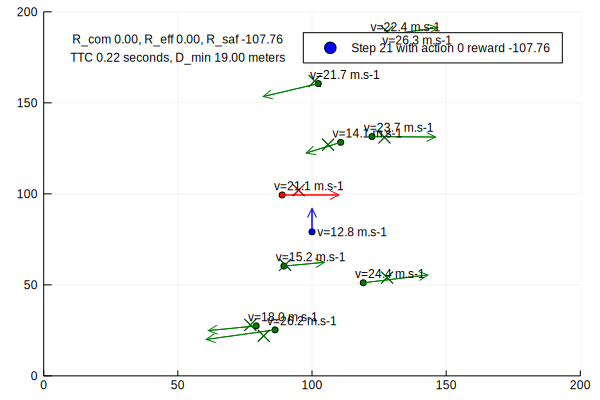

In [53]:
plots[22]

## Visualization
The results of this simulation can be visualized as a gif animation.  
  

In [54]:
using Reel

In [55]:
frames = Frames(MIME("image/png"), fps=5)
for plt in plots
    print(".")
    push!(frames, plt)
end
write("img/visu10objs.gif", frames)

.........................................................

"img/visu10objs.gif"

In [56]:
HTML("""<img src="img/visu10objs.gif"/>""")

HTML{String}("<img src=\"img/visu10objs.gif\"/>")

In [ ]:
?POMCPSolver

## Tree Visualization

In [ ]:
using POMDPModels
using POMDPModelTools
using D3Trees

The search tree can be visualized with D3Trees.jl after running the action_info() as in the example below. Note: tree_in_info must be set to true either as a solver option or as a keyword argument to action_info() for this to work (it is disabled by default because it can use a lot of memory).

In [ ]:
pomdp = TrajPOMDP()

#solver = POMCPSolver(tree_queries=1000, c=10)
solver = POMCPSolver(tree_queries=500, c=10, tree_in_info=true, experimental_ttc1=true)
#solver = POMCPSolver(tree_queries=500, c=10)

planner = solve(solver, pomdp);
a, info = action_info(planner, initialstate_distribution(pomdp), tree_in_info=true);

In [ ]:
inchrome(D3Tree(info[:tree], init_expand=6))

Testing how to aggregate observations in the tree

## Exact solution   

We have linear-Gaussian dynamics delaing with $[x,y,v_x,v_y]$ vectors  
If we can make the reward quadratic, then we could derive an exact solution as per DMU 6.4.6 and DMU 6.2.2  
Let's try at least to think about it and make a quadratic reward proposal ...  
  
** This is something that is potentially very interesting to investigate**